In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
from scipy.special import exp1,factorial
from scipy.stats import binom,nbinom

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [9]:
### Functions for theory

def get_lc(sigma,s):
    return np.sqrt(sigma**2/s)

def get_lambda_theory(w,sigma,s):
    lc = get_lc(sigma,s)
    term = (w / lc) ** 2
    if term <= 800:
        prod_term = np.exp(term) * exp1(term)
    else:
        prod_term = sum((factorial(k) / (-term)**k for k in range(7))) / term
    return (4*np.pi)/prod_term

def get_EP_theory(mu, s):
    return mu / s

def get_EPsquared_theory(mu, s, rho, sigma, w):
    lcs = get_lc(sigma, s)**2
    term = (w / np.sqrt(lcs)) ** 2
    if term <= 800:
        prod_term = np.exp(term) * exp1(term)
    else:
        prod_term = sum((factorial(k) / (-term)**k for k in range(7))) / term
    return (mu / (s ** 2 * rho * 4 * np.pi * lcs)) * prod_term + mu ** 2 / s ** 2

def get_sfs_theory(x,n,mu,s,rho,sigma,w):
    mean = get_EP_theory(mu,s)
    var = get_EPsquared_theory(mu,s,rho,sigma,w) - mean**2
    alpha = mean**2/var
    beta = mean/var
    return nbinom.pmf(x,alpha,beta/(beta+n))

def get_sfs_theory_unif(x,n,mu,s,N):
    mean = mu/s
    var = mu/(s*s*N)
    alpha = mean**2/var
    beta = mean/var
    return nbinom.pmf(x,alpha,beta/(beta+n))

### Comparison between theory and data

In [5]:
### Scale factors for y axis - from empiriaclplots_v20250217

len_syn = 1308.0216666666665
len_mis = 2616.043333333333
len_lof = 167.616

prop_kept_syn = 32320/247378
prop_kept_mis = 32320/505963

In [160]:
### Function to compare observed (data) to expected (theory) sfs and return chi-square statistic

def get_obs_dist(width,vartype,scale_factor,centers):
    obs_dist_list = []
    if width is not None: # not uniform
        for center in centers: # average over centers
            sfs = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vartype}_{center}geo{width}_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
            sfs_grouped = sfs.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std']) # average over replicates
            obs_dist_temp = sfs_grouped['mean'] / scale_factor
            obs_dist_list.append(obs_dist_temp)
        obs_dist = np.mean(obs_dist_list,axis=0)
    else: # uniform
        sfs = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vartype}_uniformgeo_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
        sfs_grouped = sfs.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std']) # average over replicates
        obs_dist = sfs_grouped['mean'] / scale_factor
    return obs_dist

def comp_chisq(nb_dist,width,vartype,scale_factor,centers=['centerE9N9','centerE16N4','centerE6N4']):
    obs_dist = get_obs_dist(width,vartype,scale_factor,centers)
    obs_dist = obs_dist[1:len(nb_dist)+1]
    chisq = np.sum(((nb_dist - obs_dist)**2/(nb_dist)))
    return chisq

### Function for grid search

def grid_search(sigma_list,rho_list,s_list,w_list,mu_list,width,vartype,scale_factor,max_x=10):
    chisq_results = []
    for sigma in sigma_list:
        for rho in rho_list:
            for s in s_list:
                for w in w_list:
                    for mu in mu_list:
                        nb_dist = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w) * 1000 for y in np.arange(1, max_x+1)])
                        chisq = comp_chisq(nb_dist,width,vartype,scale_factor)
                        chisq_results.append((sigma,rho,s,w,mu,chisq))
    chisq_results.sort(key=lambda x:x[5])
    return chisq_results

### Function for grid search - 2 w
def grid_search_multiw(sigma_list,rho_list,s_list,w_list,mu_list,widths,vartype,scale_factor,max_x=10):
    assert len(w_list) == len(widths), "w_list and width_list must be the same length"
    chisq_results = []
    for sigma in sigma_list:
        for rho in rho_list:
            for s in s_list:
                for mu in mu_list:
                    chisq_sum = 0
                    for i,w in enumerate(w_list):
                        nb_dist = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w) * 1000 for y in np.arange(1, max_x+1)])
                        chisq_sum += comp_chisq(nb_dist,widths[i],vartype,scale_factor)
                    chisq_results.append((sigma,rho,s,'multi',mu,chisq_sum))
    chisq_results.sort(key=lambda x:x[5])
    return chisq_results

### Function to print grid search results

def print_res(results,vt,max_rank=20):
    print(f"Ranking of parameter combinations by best fit (lowest chisq), {vt} variants:")
    for rank, (sigma, rho, s, w, mu, chisq) in enumerate(results, 1):
        if rank<=max_rank:
            print(f"{rank}. sigma={sigma}, rho={rho}, s={s:.1e}, w={w}, mu={mu:.2e}, chisq={chisq:.5f}")

Optimize using one value of w... 

In [162]:
sigma_list = np.linspace(1,100,10)
rho_list = np.linspace(0.1,50,10)
s_list = np.logspace(-4,-2,10)
w_list = [50]
mu_list = [1.25e-8]
width = '50000'
vartype = 'missense'
scale_factor = len_mis*prop_kept_mis

In [163]:
res = grid_search(sigma_list,rho_list,s_list,w_list,mu_list,width,vartype,scale_factor,max_x=10)
print_res(res,'missense')

Ranking of parameter combinations by best fit (lowest chisq), missense variants:
1. sigma=1.0, rho=22.27777777777778, s=6.0e-03, w=50, mu=1.25e-08, chisq=1.70578
2. sigma=1.0, rho=16.733333333333334, s=6.0e-03, w=50, mu=1.25e-08, chisq=1.75806
3. sigma=1.0, rho=16.733333333333334, s=3.6e-03, w=50, mu=1.25e-08, chisq=1.99171
4. sigma=100.0, rho=0.1, s=3.6e-03, w=50, mu=1.25e-08, chisq=2.04051
5. sigma=12.0, rho=5.644444444444444, s=6.0e-03, w=50, mu=1.25e-08, chisq=2.10282
6. sigma=1.0, rho=22.27777777777778, s=3.6e-03, w=50, mu=1.25e-08, chisq=2.26175
7. sigma=1.0, rho=27.822222222222223, s=6.0e-03, w=50, mu=1.25e-08, chisq=2.46493
8. sigma=89.0, rho=0.1, s=3.6e-03, w=50, mu=1.25e-08, chisq=2.47756
9. sigma=1.0, rho=27.822222222222223, s=3.6e-03, w=50, mu=1.25e-08, chisq=2.94195
10. sigma=1.0, rho=11.188888888888888, s=3.6e-03, w=50, mu=1.25e-08, chisq=3.09300
11. sigma=78.0, rho=0.1, s=2.2e-03, w=50, mu=1.25e-08, chisq=3.21554
12. sigma=67.0, rho=0.1, s=2.2e-03, w=50, mu=1.25e-08, chi

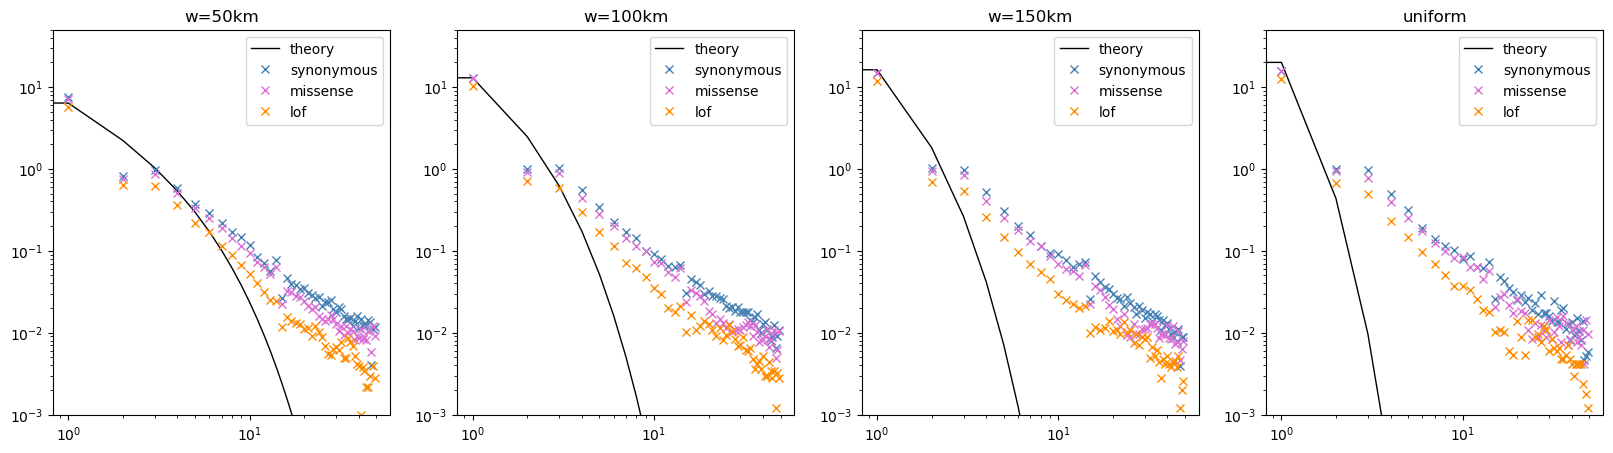

In [169]:
### plot data vs. theory - best fit params

centers = ['centerE9N9','centerE16N4','centerE6N4']
widths_data = ['50000','100000','150000',None]
vartypes = ['synonymous','missense','lof']
scale_factors = [len_syn*prop_kept_syn,len_mis*prop_kept_mis,len_lof]
colors=['steelblue','orchid','darkorange']
maxval=50
fig,ax = plt.subplots(1,4,figsize=(20,5))

# plot_theory
widths_theory = [50,100,150,500]
s = 6e-03
mu = 1.25e-8
sigma = 1.0
rho = 22.2778
for j,w in enumerate(widths_theory):
    nb_dist = [get_sfs_theory(y, n, mu, s, rho, sigma, w)*1000 for y in np.arange(0, maxval)]
    ax[j].loglog(np.arange(0, maxval), nb_dist, marker=None, linestyle='-',linewidth=1, alpha=1, color='black',label=f'theory')

# plot data
for j, wid in enumerate(widths_data):
    for i, vt in enumerate(vartypes):
        sfs = get_obs_dist(wid,vt,scale_factors[i],centers=centers)
        ax[j].loglog(np.arange(0,maxval),sfs[:maxval],marker='x',color=colors[i],linestyle='',label=vartypes[i])

for i in [0,1,2,3]:
    ax[i].set_ylim(1e-3,5e1)
    ax[i].legend()

ax[0].set_title('w=50km')
ax[1].set_title('w=100km')
ax[2].set_title('w=150km')
ax[3].set_title('uniform')

plt.show()

Optimize using two values of w...

In [165]:
### version with multiple w's in optimization - 2 w's
w_list = [50,100]
widths = ['50000','100000']

In [166]:
res_2w = grid_search_multiw(sigma_list,rho_list,s_list,w_list,mu_list,widths,vartype,scale_factor,max_x=10)
print_res(res_2w,'missense')

Ranking of parameter combinations by best fit (lowest chisq), missense variants:
1. sigma=1.0, rho=11.188888888888888, s=3.6e-03, w=multi, mu=1.25e-08, chisq=6.29777
2. sigma=1.0, rho=16.733333333333334, s=3.6e-03, w=multi, mu=1.25e-08, chisq=6.46909
3. sigma=12.0, rho=5.644444444444444, s=3.6e-03, w=multi, mu=1.25e-08, chisq=8.24196
4. sigma=100.0, rho=0.1, s=3.6e-03, w=multi, mu=1.25e-08, chisq=9.16564
5. sigma=1.0, rho=11.188888888888888, s=6.0e-03, w=multi, mu=1.25e-08, chisq=9.29565
6. sigma=1.0, rho=11.188888888888888, s=2.2e-03, w=multi, mu=1.25e-08, chisq=9.97707
7. sigma=12.0, rho=5.644444444444444, s=6.0e-03, w=multi, mu=1.25e-08, chisq=10.10839
8. sigma=1.0, rho=22.27777777777778, s=3.6e-03, w=multi, mu=1.25e-08, chisq=10.14989
9. sigma=89.0, rho=0.1, s=2.2e-03, w=multi, mu=1.25e-08, chisq=10.35521
10. sigma=78.0, rho=0.1, s=2.2e-03, w=multi, mu=1.25e-08, chisq=10.96449
11. sigma=100.0, rho=0.1, s=2.2e-03, w=multi, mu=1.25e-08, chisq=10.98672
12. sigma=89.0, rho=0.1, s=3.6e-

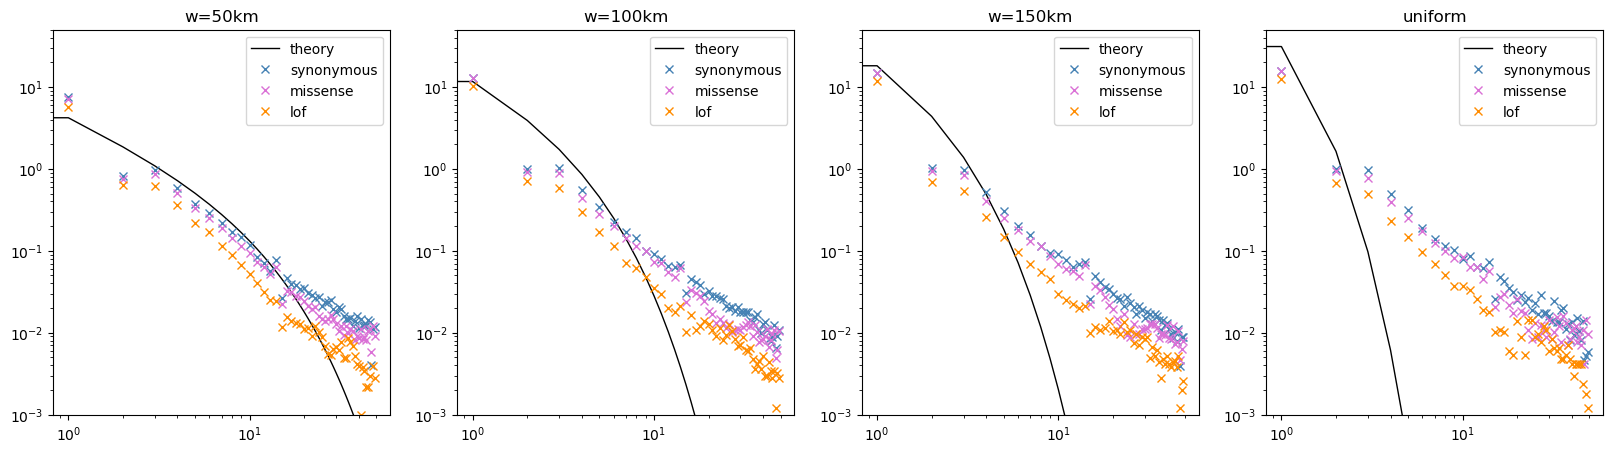

In [170]:
### plot data vs. theory - best fit params

fig,ax = plt.subplots(1,4,figsize=(20,5))
# plot_theory
widths_theory = [50,100,150,500]
s = 3.6e-03
mu = 1.25e-8
sigma = 1
rho = 11.1889
for j,w in enumerate(widths_theory):
    nb_dist = [get_sfs_theory(y, n, mu, s, rho, sigma, w)*1000 for y in np.arange(0, maxval)]
    ax[j].loglog(np.arange(0, maxval), nb_dist, marker=None, linestyle='-',linewidth=1, alpha=1, color='black',label=f'theory')

# plot data
for j, wid in enumerate(widths_data):
    for i, vt in enumerate(vartypes):
        sfs = get_obs_dist(wid,vt,scale_factors[i],centers=centers)
        ax[j].loglog(np.arange(0,maxval),sfs[:maxval],marker='x',color=colors[i],linestyle='',label=vartypes[i])

for i in [0,1,2,3]:
    ax[i].set_ylim(1e-3,5e1)
    ax[i].legend()

ax[0].set_title('w=50km')
ax[1].set_title('w=100km')
ax[2].set_title('w=150km')
ax[3].set_title('uniform')

plt.show()

All 3 values of w used...

In [171]:
### version with multiple w's in optimization - 3 w's

w_list = [50,100,150]
widths = ['50000','100000','150000']

In [172]:
res_3w = grid_search_multiw(sigma_list,rho_list,s_list,w_list,mu_list,widths,vartype,scale_factor,max_x=10)
print_res(res_3w,'missense')

Ranking of parameter combinations by best fit (lowest chisq), missense variants:
1. sigma=1.0, rho=11.188888888888888, s=3.6e-03, w=multi, mu=1.25e-08, chisq=14.97290
2. sigma=100.0, rho=0.1, s=3.6e-03, w=multi, mu=1.25e-08, chisq=17.58227
3. sigma=12.0, rho=5.644444444444444, s=3.6e-03, w=multi, mu=1.25e-08, chisq=17.66863
4. sigma=100.0, rho=0.1, s=2.2e-03, w=multi, mu=1.25e-08, chisq=17.90373
5. sigma=89.0, rho=0.1, s=2.2e-03, w=multi, mu=1.25e-08, chisq=17.91119
6. sigma=78.0, rho=0.1, s=2.2e-03, w=multi, mu=1.25e-08, chisq=20.03611
7. sigma=1.0, rho=11.188888888888888, s=2.2e-03, w=multi, mu=1.25e-08, chisq=20.70400
8. sigma=1.0, rho=5.644444444444444, s=3.6e-03, w=multi, mu=1.25e-08, chisq=21.18479
9. sigma=89.0, rho=0.1, s=3.6e-03, w=multi, mu=1.25e-08, chisq=23.41080
10. sigma=1.0, rho=5.644444444444444, s=2.2e-03, w=multi, mu=1.25e-08, chisq=23.91201
11. sigma=67.0, rho=0.1, s=1.3e-03, w=multi, mu=1.25e-08, chisq=24.28445
12. sigma=56.0, rho=0.1, s=1.3e-03, w=multi, mu=1.25e-0

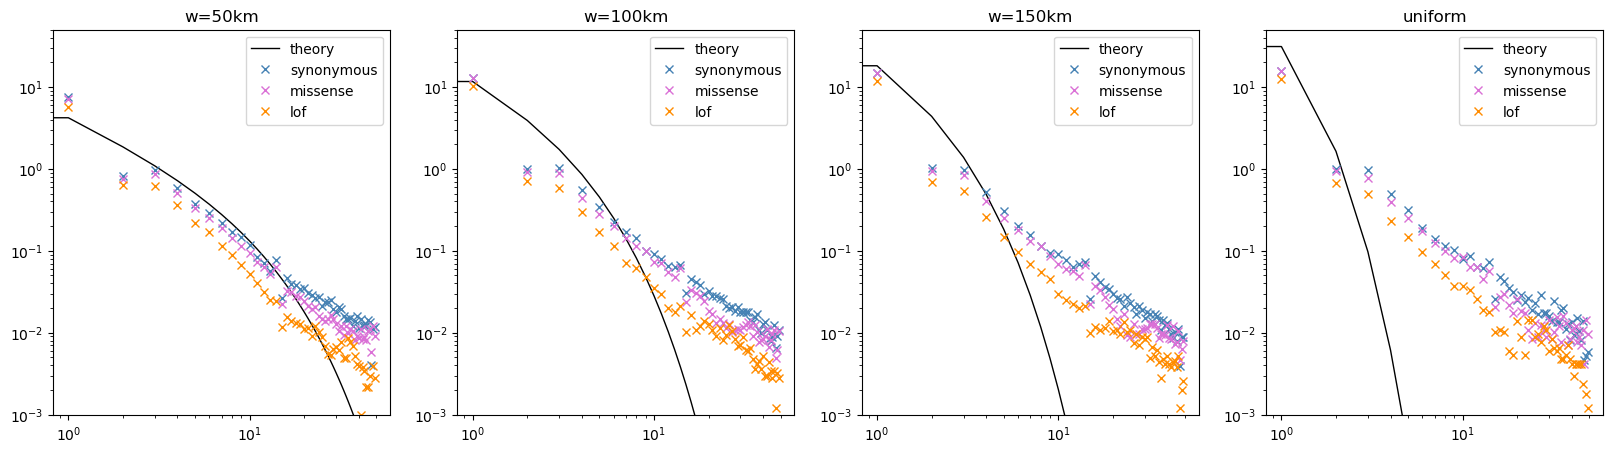

In [173]:
### plot data vs. theory - best fit params (same as 2 w case)

fig,ax = plt.subplots(1,4,figsize=(20,5))

# plot_theory
widths_theory = [50,100,150,500]
s = 3.6e-03
mu = 1.25e-8
sigma = 1
rho = 11.1889
for j,w in enumerate(widths_theory):
    nb_dist = [get_sfs_theory(y, n, mu, s, rho, sigma, w)*1000 for y in np.arange(0, maxval)]
    ax[j].loglog(np.arange(0, maxval), nb_dist, marker=None, linestyle='-',linewidth=1, alpha=1, color='black',label=f'theory')

# plot data
for j, wid in enumerate(widths_data):
    for i, vt in enumerate(vartypes):
        sfs = get_obs_dist(wid,vt,scale_factors[i],centers=centers)
        ax[j].loglog(np.arange(0,maxval),sfs[:maxval],marker='x',color=colors[i],linestyle='',label=vartypes[i])

for i in [0,1,2,3]:
    ax[i].set_ylim(1e-3,5e1)
    ax[i].legend()

ax[0].set_title('w=50km')
ax[1].set_title('w=100km')
ax[2].set_title('w=150km')
ax[3].set_title('uniform')

plt.show()